<H3> In this notebooke we actually create the VAE and train on the stock chart images

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

data_input_dir='dataset//'
image_count = 100

#load image_count images as np arrays and convert to torch tensor
dataset = torch.tensor(np.asarray([np.load(data_input_dir+'0-'+str(i)+'.npy') for i in range(image_count)]),dtype=torch.float)
print(dataset.shape)






torch.Size([100, 3, 100, 104])


<h3>Dataloader to create batches and shuffle the data

In [2]:
batch_size=100
#sampler= torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [3]:
class AE(torch.nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    self.encoder = torch.nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(1, 1), stride=(1),padding=1),
        torch.nn.ReLU(),
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1),padding=1),
        torch.nn.ReLU(),
        nn.Conv2d(3, 64, kernel_size=(1, 1), stride=(1),padding=1),
        torch.nn.ReLU(),
        nn.Conv2d(3, 64, kernel_size=(1, 1), stride=(2),padding=1),
        torch.nn.ReLU(),
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1),padding=1),
        torch.nn.ReLU(),
        nn.Conv2d(3, 64, kernel_size=(1, 1), stride=(1),padding=1),
        torch.nn.ReLU(),
        
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2),padding=1),
        
        nn.Conv2d(32, 64, kernel_size=(2, 2), stride=(1)),
        torch.nn.ReLU(),
        nn.MaxPool2d(kernel_size=(1, 1), stride=(1)),
        
        nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(1)),
        torch.nn.ReLU(),

        nn.MaxPool2d(kernel_size=(1, 1), stride=(1))
      )

    self.decoder = torch.nn.Sequential(        
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1),padding=1),
        torch.nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1)),
        torch.nn.ReLU(),
        nn.Upsample(scale_factor=1, mode='nearest'),
        nn.Conv2d(32, 3, kernel_size=(4, 4), stride=(1, 1))
    )

  def forward(self, x):
    latent = self.encoder(x)
    x_out = self.decoder(latent)
    return x_out




In [4]:
torch.cuda.empty_cache()
# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
lr=0.02
model = AE().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list=[]
# Train the model
for epoch in range(5000):
    for idx, (images) in enumerate(data_loader):
        images.to('cuda')
        output = model(images.to('cuda')).to('cuda')
        loss = criterion(output, images.to('cuda'))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_list.append(loss.item())

    # Print loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')


Epoch [10/10], Loss: 0.1751
Epoch [20/10], Loss: 0.1336
Epoch [30/10], Loss: 0.0974
Epoch [40/10], Loss: 0.0913
Epoch [50/10], Loss: 0.0892
Epoch [60/10], Loss: 0.0876
Epoch [70/10], Loss: 0.0863
Epoch [80/10], Loss: 0.0852
Epoch [90/10], Loss: 0.0843
Epoch [100/10], Loss: 0.0839
Epoch [110/10], Loss: 0.0821
Epoch [120/10], Loss: 0.0816
Epoch [130/10], Loss: 0.0817
Epoch [140/10], Loss: 0.0803
Epoch [150/10], Loss: 0.0800
Epoch [160/10], Loss: 0.0790
Epoch [170/10], Loss: 0.0786
Epoch [180/10], Loss: 0.0777
Epoch [190/10], Loss: 0.0776
Epoch [200/10], Loss: 0.0764
Epoch [210/10], Loss: 0.0756
Epoch [220/10], Loss: 0.0750
Epoch [230/10], Loss: 0.0747
Epoch [240/10], Loss: 0.0740
Epoch [250/10], Loss: 0.0754
Epoch [260/10], Loss: 0.0734
Epoch [270/10], Loss: 0.0735
Epoch [280/10], Loss: 0.0745
Epoch [290/10], Loss: 0.0730
Epoch [300/10], Loss: 0.0721
Epoch [310/10], Loss: 0.0753
Epoch [320/10], Loss: 0.0724
Epoch [330/10], Loss: 0.0714
Epoch [340/10], Loss: 0.0750
Epoch [350/10], Loss: 0

Text(0.5, 1.0, 'Loss Curve')

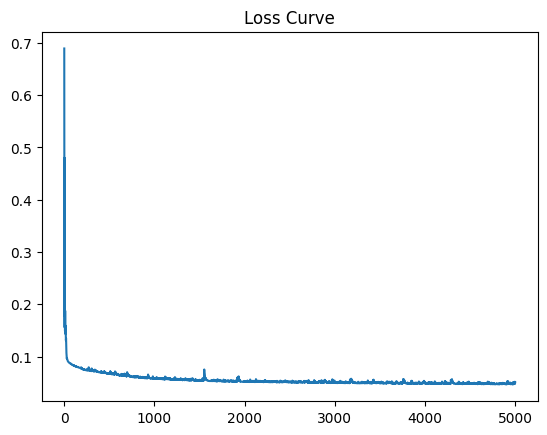

In [5]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title('Loss Curve')

In [6]:
torch.max(output[0])

tensor(11.9227, device='cuda:0', grad_fn=<MaxBackward1>)

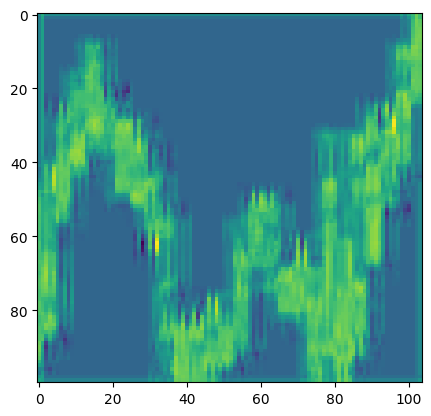

In [7]:
import matplotlib.pyplot as plt
for i in range(1):
    plt.figure()
    plt.imshow(output[i][2].to('cpu').detach())

In [10]:
np.save('test.npy',np.round(torch.sigmoid(output[0,:,:,:].to('cpu').detach())))
np.save('test_real.npy',np.round(torch.sigmoid(images[0,:,:,:].to('cpu').detach())))

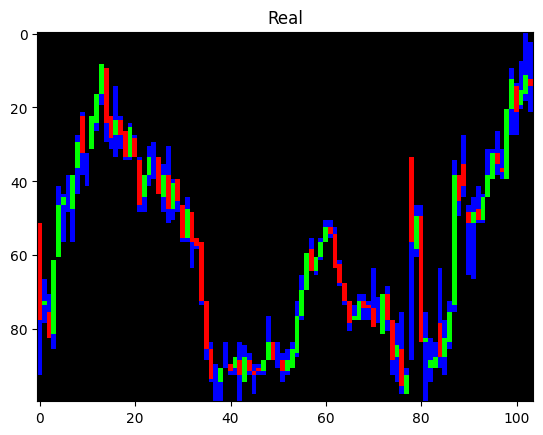

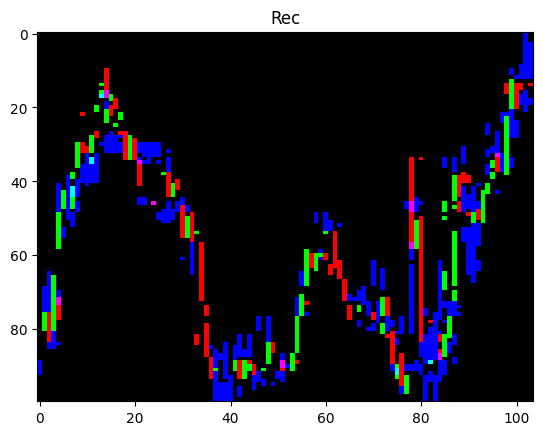

In [11]:

plt.title("Real")
plt.imshow(np.load('test_real.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

plt.title("Rec")
plt.imshow(np.load('test.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()


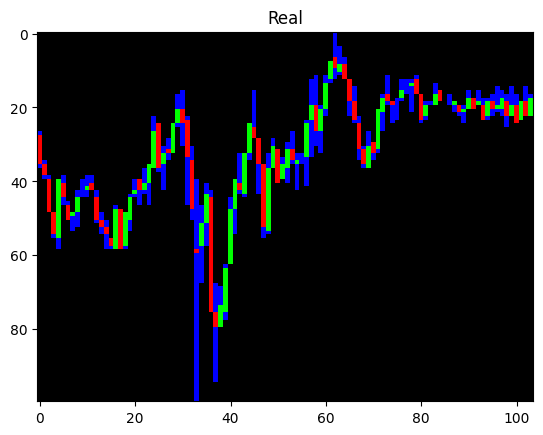

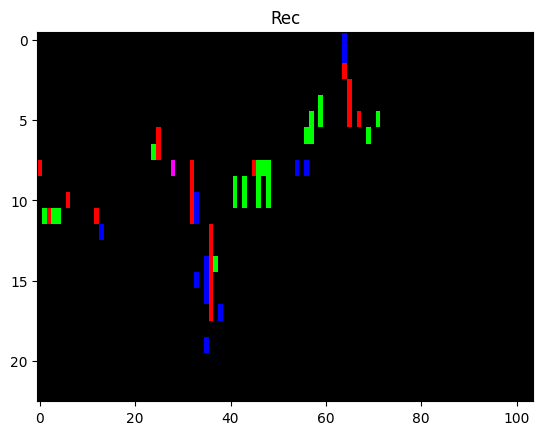

In [12]:
# testing new pics
t2 = torch.tensor(np.asarray(np.load('dataset/0-123.npy')),dtype=torch.float).to('cuda')
t2_p = np.round(torch.sigmoid(model(t2).to('cpu').detach()))

np.save('test.npy',np.round(torch.sigmoid(t2_p.to('cpu').detach())))
np.save('test_real.npy',np.round(torch.sigmoid(t2.to('cpu').detach())))


plt.title("Real")
plt.imshow(np.load('test_real.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

plt.title("Rec")
plt.imshow(np.load('test.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

In [ ]:
class AE(torch.nn.Module):
  def __init__(self, channels):
    super(AE, self).__init__()
    self.channels=channels
    size = 100
    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(3,100,kernel_size=(3),padding='same'),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(100,50,kernel_size=(3), padding='same'),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(50,50,kernel_size=(3), padding='same'),
        torch.nn.ReLU(),
      )

    self.bottleneck = torch.nn.Sequential(
        torch.nn.MaxPool2d(2)
      )

    self.decoder = torch.nn.Sequential(        
        torch.nn.Conv2d(50,50,kernel_size=(3), padding='same'),
        torch.nn.ReLU(),
        torch.nn.Upsample(2),
        torch.nn.Conv2d(100,50,kernel_size=(3), padding='same'),
        torch.nn.ReLU(),
        torch.nn.Upsample(2),
        torch.nn.Conv2d(100,50,kernel_size=(3), padding='same'),
        
        
    )

  def forward(self, x):
    latent = self.encoder(x)
    squished= self.bottleneck(torch.flatten(latent, start_dim=1, end_dim=-1))
    squished= torch.reshape(squished, (-1,self.channels*2,50,52))
    x_out = self.decoder(squished)
    return x_out

model = AE(channels=25).to('cpu')



In [43]:
dataset[0].shape

torch.Size([3, 100, 100])

In [111]:
a = torch.nn.Conv2d(3,100,kernel_size=(3),padding='same')
b = torch.nn.ReLU()
c = torch.nn.MaxPool2d((2,2))
d = torch.nn.Conv2d(100,50,kernel_size=(3), padding='same')
e = torch.nn.ReLU()
f = torch.nn.MaxPool2d((2,2))
g = torch.nn.Conv2d(50,50,kernel_size=(3), padding='same')
h = torch.nn.ReLU()

i = torch.nn.MaxPool2d((2,2))


j = torch.nn.Conv2d(50,50,kernel_size=(3),padding='same')
k = torch.nn.ConvTranspose2d(50,100,kernel_size=(3), padding='same')
l = torch.nn.Conv2d(50,50,kernel_size=(3),padding='same')
m = torch.nn.Upsample((2,2),mode='nearest')

print(out_9.shape)
print(out_10.shape)

out_0 = a(dataset[0])
out_1 = b(out_0)
out_2 = c(out_1)
out_3 = d(out_2)
out_4 = e(out_3)
out_5 = f(out_4)
out_6 = g(out_5)
out_7 = h(out_6)
out_8 = i(out_7)
out_9 = j(out_8)
out_10 = k(out_9)
# out_11 = j(out_10)
# out_12 = k(out_11)



print(out_9.shape)
print(out_10.shape)
# print(out_11.shape)
# print(out_12.shape)

torch.Size([12, 12, 12])
torch.Size([50, 12, 2])


TypeError: conv_transpose2d(): argument 'padding' (position 5) must be tuple of ints, not tuple

In [98]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(out_0[9,0,:,:].detach())
plt.figure()
plt.imshow(out_1[9,0,:,:].detach())
plt.figure()
plt.imshow(out_2[9,0,:,:].detach())
plt.figure(figsize=(10,10))
#plt.imshow(flat_out_2[0,:].detach())
plt.imshow(out_3.detach())

IndexError: too many indices for tensor of dimension 3

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
plt.imshow(up_0[0,0,:,:].detach())
plt.figure()
plt.imshow(up_1[0,0,:,:].detach())
plt.figure()
plt.imshow(up_2[0,0,:,:].detach())
plt.figure()
plt.imshow(up_3[0,0,:,:].detach())

In [233]:
torch.Size([4, 25, 26])

torch.Size([4, 25, 26])

In [251]:
dataset.shape

torch.Size([1, 3, 100, 100])